In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
x1 = np.load('dataset/LSTM_x1.npy')
x2 = np.load('dataset/LSTM_x2.npy')

In [3]:
from sklearn.model_selection import train_test_split

x = np.array(list(zip(x1, x2)))
del x1, x2

x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.3)
del x

x1_train, x2_train = x_train[:, 0], x_train[:, 1]
del x_train

x_test, x_val, y_test, y_val = train_test_split(x_val,y_val,test_size=0.5)

x1_test, x2_test = x_test[:, 0], x_test[:, 1]
x1_val, x2_val = x_val[:, 0], x_val[:, 1]

del x_test, x_val

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.02,
        zoom_range=[0.9, 1.25],
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode="reflect") #'nearest'
val_datagen = ImageDataGenerator()

In [5]:
train_datagen.fit(x1_train)
val_datagen.fit(x1_val)

In [6]:
train = train_datagen.flow([x1_train, x2_train], y_train, batch_size=16)
validation = val_datagen.flow([x1_val, x2_val], y_val, batch_size=8)

In [7]:
import matplotlib.pyplot as plt

def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

0.90991527


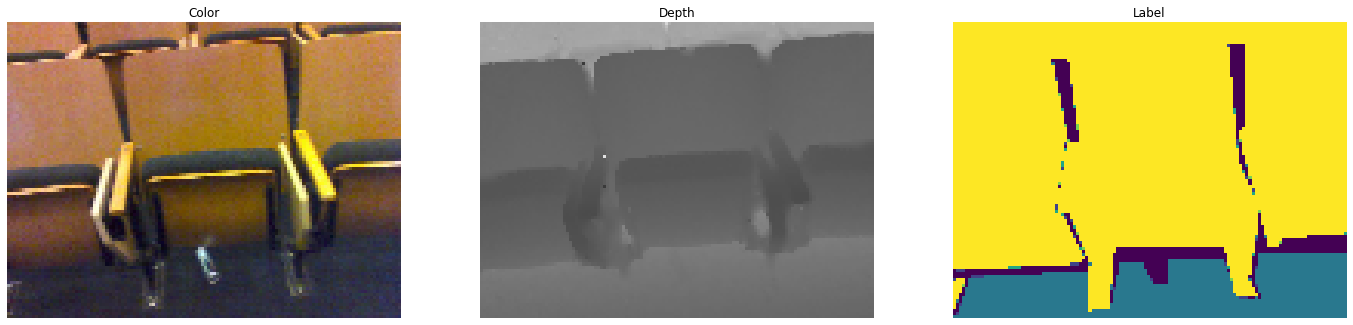

In [8]:
fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

number = 1

ax = fig.add_subplot(1, 3, 1)
plot_color(ax, x1_train[1])

ax = fig.add_subplot(1, 3, 2)
plot_depth(ax, x2_train[1])
print(np.max(x2_train[0]))

ax = fig.add_subplot(1, 3, 3)
plot_label(ax, np.argmax(y_train[1],axis=-1))

plt.show()

In [2]:
class MyModel():

    def __init__(self):
        '''
        Crear el modelos para segmentación
        '''
        self.input_rgb = tf.keras.layers.Input(shape=(16,96,128,3),dtype=tf.float32,name='input_1')
        self.input_depth = tf.keras.layers.Input(shape=(16,96,128,3),dtype=tf.float32,name='input_2')
        self.fusion_1 = None
        self.fusion_2 = None
#         self.fusion_3 = None

    def rgbd_fusion(self,input_r,input_d,capa):
        r = tf.keras.layers.GlobalAveragePooling3D()(input_r)
        r = tf.keras.layers.Reshape((1,1,1,64*capa))(r)
        r = tf.keras.layers.ConvLSTM2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu', return_sequences=True)(r)
        r = tf.keras.layers.ConvLSTM2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid', return_sequences=True)(r)
        m_1 = tf.keras.layers.Multiply()([input_r,r])
        
        d = tf.keras.layers.GlobalAveragePooling3D()(input_d)
        d = tf.keras.layers.Reshape((1,1,1,64*capa))(d)
        d = tf.keras.layers.ConvLSTM2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu', return_sequences=True)(d)
        d = tf.keras.layers.ConvLSTM2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid', return_sequences=True)(d)
        m_2 = tf.keras.layers.Multiply()([input_d,d])
        
        return tf.keras.layers.Add()([m_1,m_2])

    def resnet_layer(self,input_res, input_add, filters):
        x = tf.keras.layers.ConvLSTM2D(filters, (3,3), padding='same', return_sequences=True)(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.ConvLSTM2D(filters, (3,3), padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.ConvLSTM2D(filters, (3,3), padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.ConvLSTM2D(filters, (3,3), padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x
    
    def resnet_layer_div(self,input_res, input_add, filters):
        x = tf.keras.layers.ConvLSTM2D(filters, (3,1), padding='same', strides=(2,1), return_sequences=True)(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.ConvLSTM2D(filters, (1,3), padding='same', strides=(1,2), return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.ConvLSTM2D(filters, (3,1), padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.ConvLSTM2D(filters, (1,3), padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)

        return x
    
    def bottleneck_layer(self,input_bo,filters):
        x = tf.keras.layers.ConvLSTM2D(filters, kernel_size=(3,1), activation='relu', padding='same', return_sequences=True)(input_bo)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ConvLSTM2D(filters, kernel_size=(1,3), activation='relu', padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ConvLSTM2D(filters, kernel_size=(3,1), activation='relu', padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ConvLSTM2D(filters, kernel_size=(1,3), activation='relu', padding='same', return_sequences=True)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, input_bo])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def decode_layer(self,input_de,input_add,filters):
        x = tf.keras.layers.ConvLSTM2D(filters,kernel_size=(3,3),activation='relu', padding='same', return_sequences=True)(input_de)
        x = self.bottleneck_layer(x, filters)
        x = tf.keras.layers.UpSampling3D(size=(1,2,2))(x)
        x_2 = tf.keras.layers.ConvLSTM2D(filters, kernel_size=(1,1), activation='relu', padding='same', return_sequences=True)(input_add)
        x = tf.keras.layers.Add()([x, x_2])
        return x
        
    def model(self):

        # Preparar la entrada de datos
        xr = tf.keras.layers.ConvLSTM2D(64,kernel_size=(3,3),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu', return_sequences=True)(self.input_rgb)
        xd = tf.keras.layers.ConvLSTM2D(64,kernel_size=(3,3),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu', return_sequences=True)(self.input_depth)

        # Fusion
        xr = self.rgbd_fusion(xr,xd,1)

        # Preparar para encoder
        xr = tf.keras.layers.MaxPool3D(pool_size=(1,3,3), strides=(1,2,2), padding='same')(xr)
        xd = tf.keras.layers.MaxPool3D(pool_size=(1,3,3), strides=(1,2,2), padding='same')(xd)

        ''' ENCODER'''
        # PRIMERA CAPA
        xr = self.resnet_layer(xr,xr,64)
        xd = self.resnet_layer(xd,xd,64)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,1)
        self.fusion_1 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # SEGUNDA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.ConvLSTM2D(128,kernel_size=(1,1),strides=(2,2), return_sequences=True)(xr),128)
        xd = self.resnet_layer_div(xd,tf.keras.layers.ConvLSTM2D(128,kernel_size=(1,1),strides=(2,2), return_sequences=True)(xd),128)

        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,128)
            xd = self.resnet_layer(xd,xd,128)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,2)
        self.fusion_2 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.
        
        # TERCERA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.ConvLSTM2D(256,kernel_size=(1,1),strides=(2,2), return_sequences=True)(xr),256)
        xd = self.resnet_layer_div(xd,tf.keras.layers.ConvLSTM2D(256,kernel_size=(1,1),strides=(2,2), return_sequences=True)(xd),256)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,4)
        self.fusion_3 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # CUARTA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.ConvLSTM2D(512,kernel_size=(1,1),strides=(2,2), return_sequences=True)(xr),512)
        xd = self.resnet_layer_div(xd,tf.keras.layers.ConvLSTM2D(512,kernel_size=(1,1),strides=(2,2), return_sequences=True)(xd),512)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,8)

        '''DECODER'''

        xr = self.decode_layer(xr,self.fusion_3,512)
        xr = self.decode_layer(xr,self.fusion_2,256)
        xr = self.decode_layer(xr,self.fusion_1,256)
        
        xr = tf.keras.layers.ConvLSTM2D(150, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True)(xr)
        xr = tf.keras.layers.UpSampling3D(size=(1,2,2))(xr)
        xr = tf.keras.layers.ConvLSTM2D(150, kernel_size=(2,2), activation='relu', padding='same', return_sequences=True)(xr)
        xr = tf.keras.layers.UpSampling3D(size=(1,2,2))(xr)
        xr = tf.keras.layers.ConvLSTM2D(150, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True)(xr)

        return tf.keras.Model(inputs=[self.input_rgb, self.input_depth], outputs=xr)

In [3]:
model = MyModel().model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 96, 128, 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16, 96, 128, 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 16, 48, 64, 6 154624      input_1[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 16, 48, 64, 6 154624      input_2[0][0]                    
______________________________________________________________________________________________

In [7]:
tf.keras.utils.plot_model(model,to_file="model.png")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

In [13]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection)/ (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
weight_path="{}_best_weights.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, min_delta=0.0001, cooldown=2, min_lr=1e-6)

def step_decay(epoch):
    lr = 0.001
    epoch_drop = 5
    reduction_percent=0.1
    if epoch % epoch_drop == 0:
        lr = lr*pow(reduction_percent,epoch / epoch_drop)
        print('New lr is: ', lr)
    return lr

lrate = LearningRateScheduler(step_decay)

early = EarlyStopping(monitor="val_loss",
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [15]:
from segmentation_models.metrics import iou_score
from segmentation_models.losses import categorical_crossentropy

model.compile(optimizer='Adam', loss=categorical_crossentropy, 
              metrics=[dice_coef, 
                       'accuracy', 
                       true_positive_rate, 
                       iou_score
                      ])

history = model.fit(train, epochs=1000, verbose=1, validation_data=validation, callbacks=callbacks_list)

Segmentation Models: using `keras` framework.
Epoch 1/1000
37/37 [==============================] - 27s 430ms/step - loss: 0.1598 - dice_coef: 0.0755 - accuracy: 0.2043 - true_positive_rate: 311.9286 - iou_score: 0.0587 - val_loss: 0.1607 - val_dice_coef: 0.0848 - val_accuracy: 0.2312 - val_true_positive_rate: 85.1464 - val_iou_score: 0.1329

Epoch 00001: val_loss improved from inf to 0.16073, saving model to seg_model_2_best_weights.hdf5
Epoch 2/1000
37/37 [==============================] - 12s 316ms/step - loss: 0.0736 - dice_coef: 0.1195 - accuracy: 0.2209 - true_positive_rate: 951.0033 - iou_score: 0.0985 - val_loss: 0.0678 - val_dice_coef: 0.1479 - val_accuracy: 0.2438 - val_true_positive_rate: 282.1300 - val_iou_score: 0.1489

Epoch 00002: val_loss improved from 0.16073 to 0.06782, saving model to seg_model_2_best_weights.hdf5
Epoch 3/1000
37/37 [==============================] - 12s 316ms/step - loss: 0.0642 - dice_coef: 0.1517 - accuracy: 0.2679 - true_positive_rate: 1253.1682 

37/37 [==============================] - 12s 320ms/step - loss: 0.0569 - dice_coef: 0.1295 - accuracy: 0.3285 - true_positive_rate: 1173.3405 - iou_score: 0.1342 - val_loss: 0.0587 - val_dice_coef: 0.1299 - val_accuracy: 0.3639 - val_true_positive_rate: 1641.7269 - val_iou_score: 0.1608

Epoch 00043: val_loss did not improve from 0.05865
Epoch 44/1000
37/37 [==============================] - 12s 324ms/step - loss: 0.0568 - dice_coef: 0.1298 - accuracy: 0.3311 - true_positive_rate: 1165.8263 - iou_score: 0.1337 - val_loss: 0.0585 - val_dice_coef: 0.1292 - val_accuracy: 0.3655 - val_true_positive_rate: 1651.2800 - val_iou_score: 0.1786

Epoch 00044: val_loss improved from 0.05865 to 0.05846, saving model to seg_model_2_best_weights.hdf5
Epoch 45/1000
37/37 [==============================] - 12s 320ms/step - loss: 0.0567 - dice_coef: 0.1283 - accuracy: 0.3351 - true_positive_rate: 1156.7449 - iou_score: 0.1402 - val_loss: 0.0584 - val_dice_coef: 0.1292 - val_accuracy: 0.3661 - val_true_po

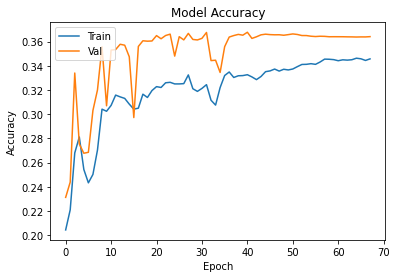

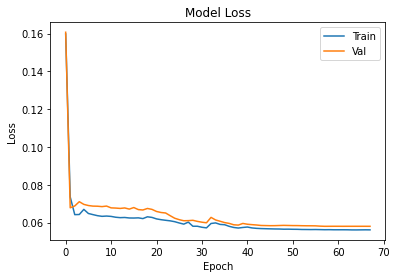

In [16]:
plot_acc(history)
plot_loss(history)

In [20]:
score = model.evaluate([x1_test,x2_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [18]:
y_pred = model.predict([x1_test[:50],x2_test[:50]])
y_classes = [np.argmax(y, axis=-1) for y in y_pred]
label = [np.argmax(y, axis=-1) for y in y_test[:50]]